In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from create_connection import create_connection
from scipy.stats import ttest_ind
import scipy.stats as stats
warnings.filterwarnings('ignore')

In [4]:
engine = create_connection()
df = pd.read_sql("SELECT * FROM vendor_sales_summary", engine)
df.size

144704

Previously we examined the various tables in the database to identify key variables, understand their relationships, and determine which ones should be included in the final analysis. 

In this phase of EDA , we will analyze the resultant table to gain insights into the distribution of each  column. This will help us understand data patterns, identify anomalies, and ensure data quality before proceeding with further anlaysis.

In [5]:
#summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorNumber,8512.0,10153.455122,17718.122212,2.000000e+00,3664.000000,7153.000000,9552.000000,1.733570e+05
Brand,8512.0,17600.258694,13004.702546,5.800000e+01,5297.750000,17432.500000,24988.000000,9.063100e+04
PurchasePrice,8512.0,21.889769,105.829821,3.600000e-01,6.800000,10.270000,18.240000,5.681810e+03
ActualPrice,8512.0,32.188422,144.210224,4.900000e-01,10.990000,15.990000,26.990000,7.499990e+03
Volume,8512.0,854.875646,617.982459,5.000000e+01,750.000000,750.000000,750.000000,2.000000e+04
TotalPurchaseQuantity,8512.0,1691.806743,5495.976429,1.000000e+00,24.000000,231.500000,1194.250000,1.607350e+05
TotalPurchaseDollars,8512.0,15786.304760,56938.112018,7.100000e-01,344.880000,2840.535000,12601.875000,1.584606e+06
TotalSalesQuantity,8512.0,307.924695,991.625095,0.000000e+00,5.000000,44.000000,219.000000,2.744200e+04
TotalSalesDollars,8512.0,4257.436606,15372.805476,0.000000e+00,107.880000,758.895000,3349.360000,4.124973e+05
TotalExciseTax,8512.0,180.156969,1009.880047,0.000000e+00,0.780000,7.450000,51.280000,3.154146e+04


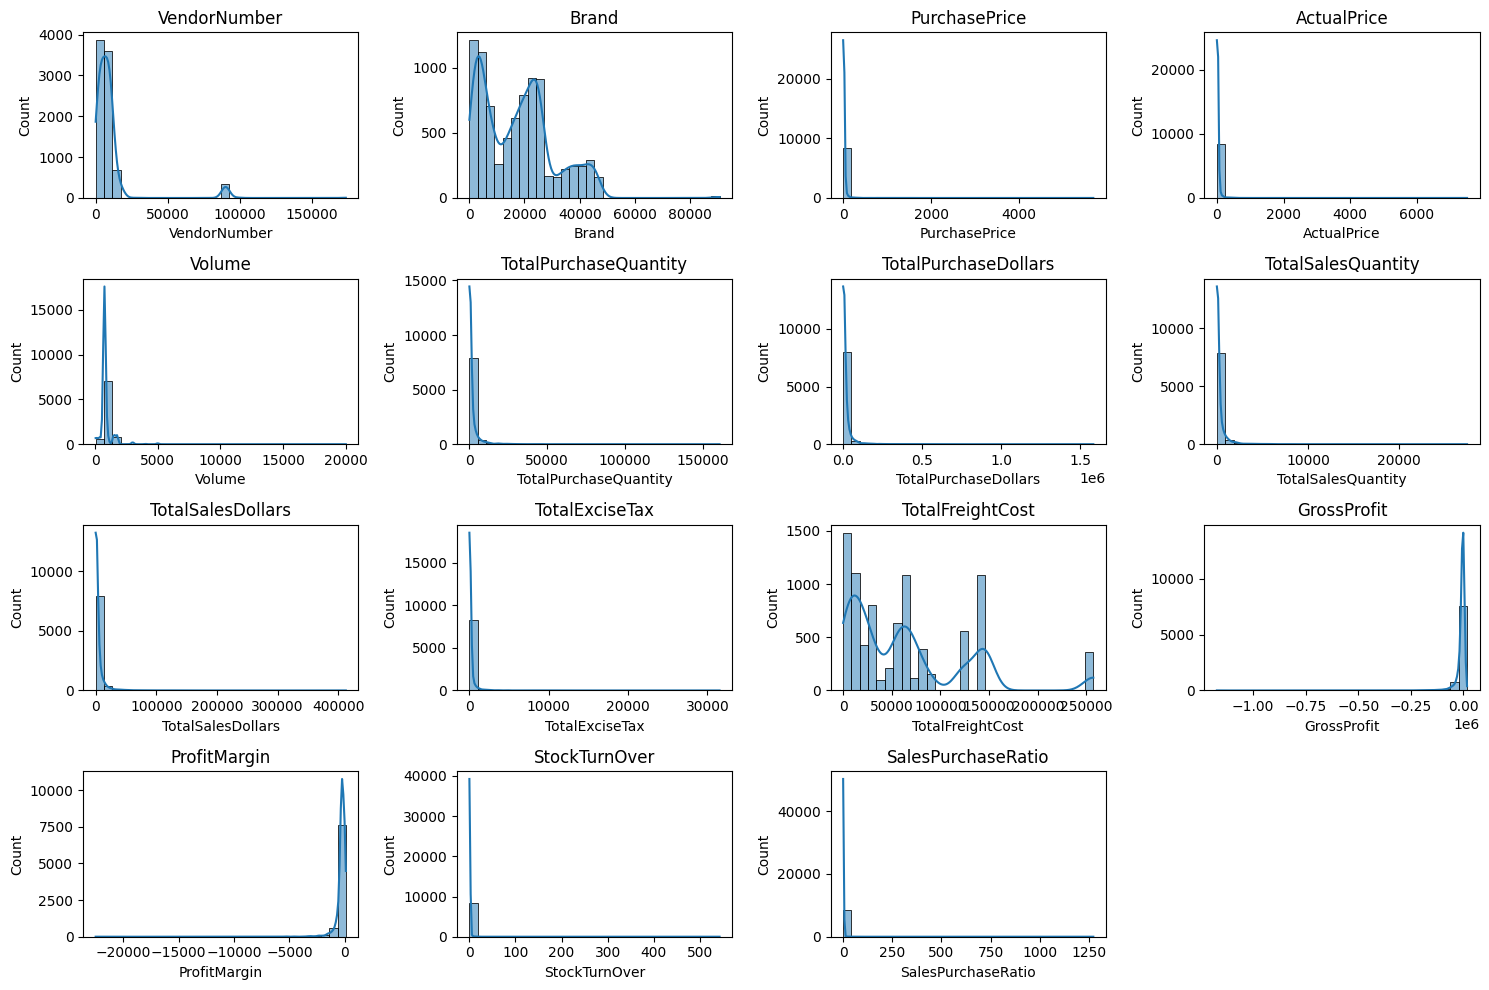

In [6]:
numerical_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15,10))
for i,col in enumerate(numerical_cols):
    plt.subplot(4,4,i+1)
    sns.histplot(df[col],kde=True,bins=30)
    plt.title(col)

plt.tight_layout()
plt.show()

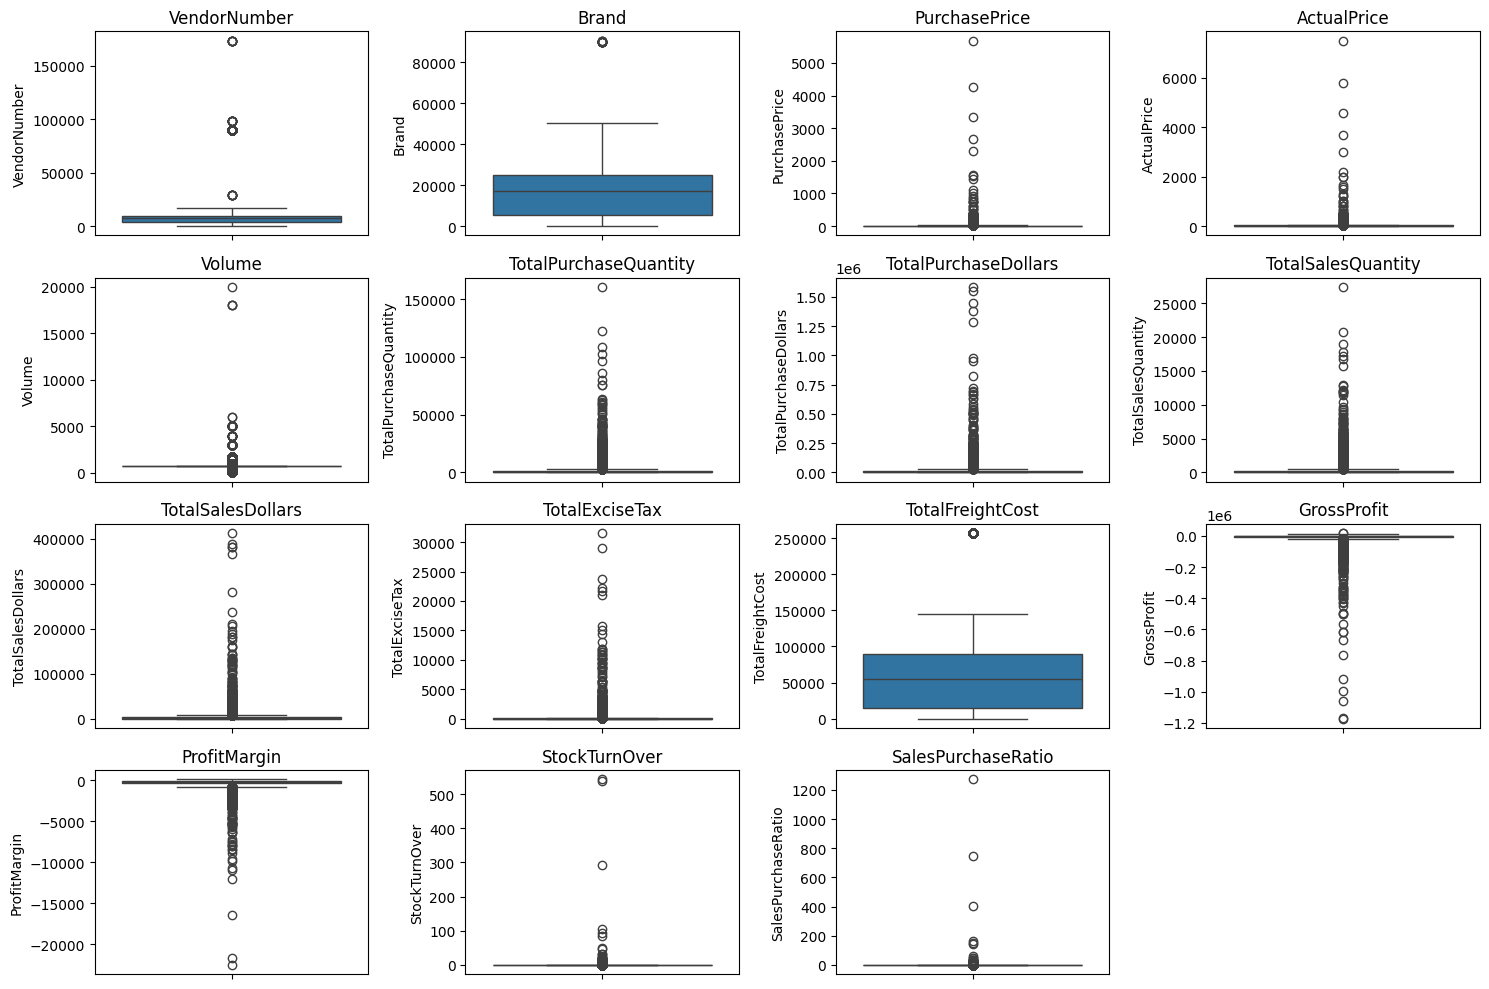

In [7]:
plt.figure(figsize=(15,10))
for i,col in enumerate(numerical_cols):
    plt.subplot(4,4,i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

<h2>Statistics Insights</h2>

<bold>Negative and Zero Values</bold>
<li>Gross profit : MIN value is -1.172109e+06 , indicating loss. Some products or tarnsactions may be selling at a loss due to high cost or selling at discounts lower than purchase price</li>
<li>Profit Margin: Has a min of -2.249955e+04 suggests cases where revenue is 0 or even lower than costs</li>
<li>Total Sales Quantity And Sales Dollars: Minimum values are 0,  meaning some products were purchased but never sold, so they could be obsolete stock</li>

<bold>Outliers Indicated by high Standard Deviation</bold>
<li>Purchases and actual prices: The max values 5.681810e+03 are significantly higher than the mean 21.889769, indicating potential premium products</li>
<li>Freight Cost: Huge variation from 2.700000e-01 to 2.570321e+05 suggests logistics ineffencies or bulk shipments</li>
<li>Stock Turnover: Some products sell extremely fast whereas other remain in stock indefinitely. Vlaue more than 1 indicates that sold quantity for that product is higher than purchased quantity due to maybe older stock. </li>

In [8]:
df = pd.read_sql_query("""
    SELECT * FROM vendor_sales_summary
    WHERE GrossProfit > 0
    AND ProfitMargin > 0
    AND  TotalSalesQuantity > 0
""", engine)

In [9]:
df

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalExciseTax,TotalFreightCost,GrossProfit,ProfitMargin,StockTurnOver,SalesPurchaseRatio
0,4425,MARTIGNETTI COMPANIES,13661,Duckhorn Decoy Pnt Nr,11.61,21.99,750.0,1434,16648.74,1146.0,21531.90,128.06,144929.24,4883.16,22.678723,0.799163,1.293305
1,4425,MARTIGNETTI COMPANIES,42874,Decoy by Duckhorn Red Sonoma,11.38,21.99,750.0,789,8978.82,587.0,11104.97,65.53,144929.24,2126.15,19.145932,0.743980,1.236796
2,4425,MARTIGNETTI COMPANIES,26383,Buehler Chard RRV,7.89,15.99,750.0,1046,8252.94,1130.0,14019.70,126.61,144929.24,5766.76,41.133262,1.080306,1.698752
3,516,BANFI PRODUCTS CORP,37433,C Y Toro Casillero Carmenere,4.32,9.99,750.0,1731,7477.92,839.0,7708.59,93.70,8510.41,230.67,2.992376,0.484691,1.030847
4,10754,PERFECTA WINES,2208,WhistlePig 10 Yr Old Rye,53.95,74.99,750.0,133,7175.35,98.0,7284.02,77.23,28720.52,108.67,1.491896,0.736842,1.015145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,3960,DIAGEO NORTH AMERICA INC,7902,Piehole Apple Pie,0.72,0.99,50.0,6,4.32,15.0,14.85,0.78,257032.07,10.53,70.909091,2.500000,3.437500
680,8004,SAZERAC CO INC,1059,Old St Nick's Egg Nog,3.40,4.49,750.0,1,3.40,92.0,551.08,72.41,50293.62,547.68,99.383030,92.000000,162.082353
681,90024,VINILANDIA USA,46135,Aresti Pnt Nr Curico Vly,3.28,10.99,750.0,1,3.28,1.0,4.99,0.11,2802.64,1.71,34.268537,1.000000,1.521341
682,3960,DIAGEO NORTH AMERICA INC,3775,Smirnoff Sorbet Pine/Coconut,0.73,0.99,50.0,1,0.73,9.0,8.91,0.46,257032.07,8.18,91.806958,9.000000,12.205479


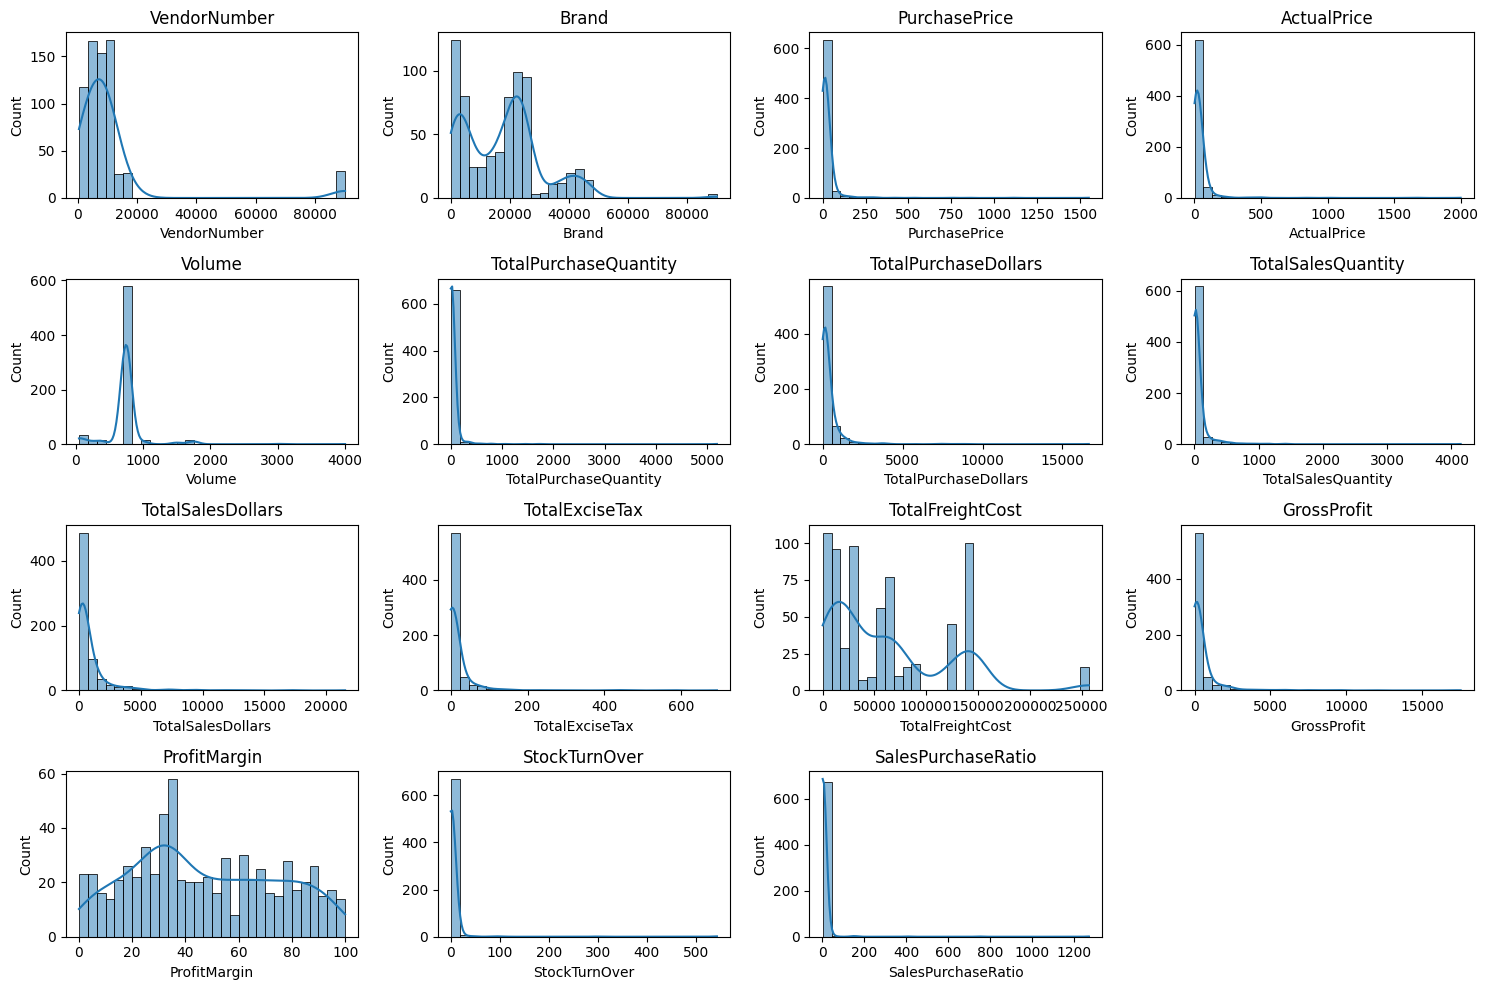

In [10]:
numerical_cols = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(15,10))
for i,col in enumerate(numerical_cols):
    plt.subplot(4,4,i+1)
    sns.histplot(df[col],kde=True,bins=30)
    plt.title(col)

plt.tight_layout()
plt.show()

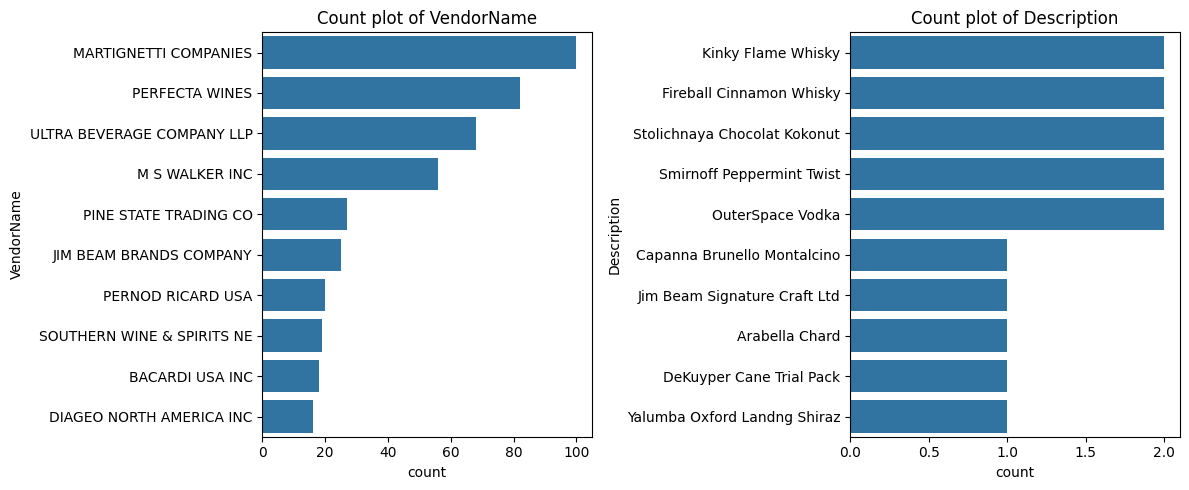

In [11]:
categorical_cols = ["VendorName", "Description"]

plt.figure(figsize=(12,5))
for i,col in enumerate(categorical_cols):
    plt.subplot(1,2,i+1)
    sns.countplot(y=df[col], order = df[col].value_counts().index[:10])
    plt.title(f"Count plot of {col}")
plt.tight_layout()
plt.show()

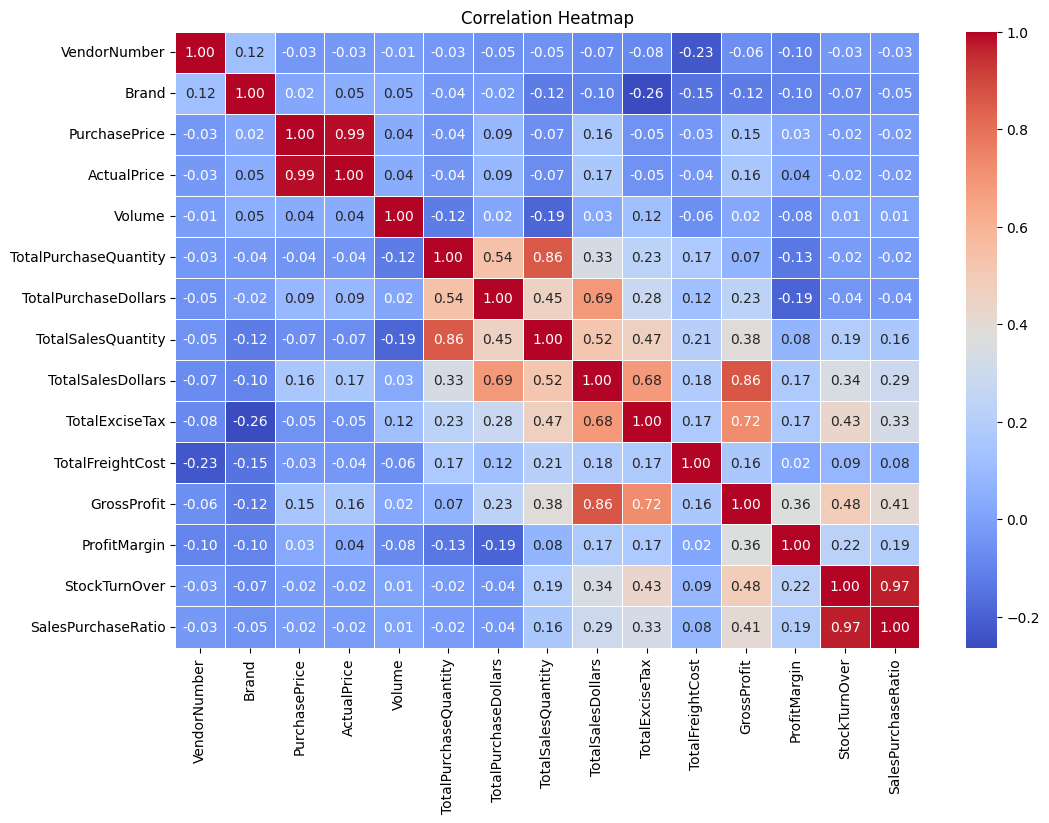

In [12]:
plt.figure(figsize=(12,8))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix,annot=True,fmt=".2f",cmap="coolwarm",linewidth=0.5)
plt.title("Correlation Heatmap")
plt.show()

<h2>Correlation Insights</h2>
<li>PurchasePrice has weak correlation with TotalSalesDollars and Gross Profit, suggestiong that price variations do not significantly impact sales revenue or profit</li>
<li>Strong Corelation between total purchase quantity and total sales quantity , confirming effiecient inventory turnover</li>
<li>Negative correlation between profit margin and total sales price suggests that as sale price increases , margin decreases, possibly due to competitive pricing pressures</li>
<li>StockTurnover has weak negative correlations with both GrossProfit and ProfitMargin, indicating that faster turnover does not necessarily result in higher profitability</li>

<h2>Data Analysis</h2>

Identifying brands that needs promotional or pricing adjustments which exhibit lower sales performance but higher profit margins

In [13]:
brand_performance_data = df.groupby('Description').agg({
    'TotalSalesDollars': 'sum', 
    'ProfitMargin': 'mean',
}).reset_index()

In [14]:
low_sales_theshold = brand_performance_data['TotalSalesDollars'].quantile(0.15)
high_margin_threshold = brand_performance_data['ProfitMargin'].quantile(0.85)

In [15]:
low_sales_theshold

85.671

In [16]:
high_margin_threshold

80.84849505386157

In [17]:
target_brands = brand_performance_data[
    (brand_performance_data['TotalSalesDollars'] <= low_sales_theshold) &
    (brand_performance_data['ProfitMargin'] >= high_margin_threshold)]

print("Brands with low sales but high profit margins:")
display(target_brands.sort_values('TotalSalesDollars'))

Brands with low sales but high profit margins:


,Description,TotalSalesDollars,ProfitMargin
572,Smirnoff Sorbet Pine/Coconut,8.91,91.806958
624,Three Olives Grape Vodka,12.87,94.483294
589,Stark Raving Cab Svgn,35.97,81.734779
585,St Elder Elderflower Liqueur,37.62,84.901648
11,Absolut Pears,49.75,84.020101
0,12 Days of Pearls Gift Set,59.94,88.004671
424,Montsarra Brut Cava,74.95,86.844563


In [25]:
brand_performance_data = brand_performance_data[brand_performance_data['TotalSalesDollars']<900]

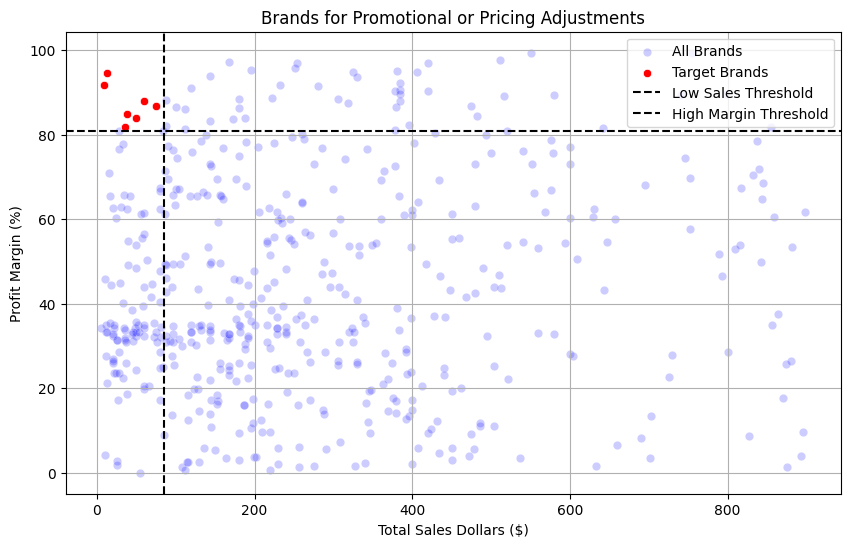

In [26]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=brand_performance_data, x='TotalSalesDollars', y='ProfitMargin',color="blue",label="All Brands",alpha = 0.2)
sns.scatterplot(data=target_brands, x='TotalSalesDollars', y='ProfitMargin',color="red",label="Target Brands")

plt.axvline(low_sales_theshold, color='black', linestyle='--', label='Low Sales Threshold')
plt.axhline(high_margin_threshold, linestyle='--' ,color='black',label='High Margin Threshold')

plt.xlabel('Total Sales Dollars ($)')
plt.ylabel('Profit Margin (%)')
plt.title('Brands for Promotional or Pricing Adjustments')
plt.legend()
plt.grid(True)
plt.show()

vendor and brand showing highest brand performance

In [30]:
def format_dollars(value):
    if value >= 1_000_000:
        return f"{value/1_000_000:.2f}M"
    elif value >= 1_000:
        return f"{value/1_000:.2f}K"
    else:
        return str(value)

In [28]:
top_vendors = df.groupby('VendorName')['TotalSalesDollars'].sum().nlargest(10)
top_brands = df.groupby('Description')['TotalSalesDollars'].sum().nlargest(10)
top_vendors

VendorName
MARTIGNETTI COMPANIES         121672.37
PERFECTA WINES                 69491.91
ULTRA BEVERAGE COMPANY LLP     59326.51
DIAGEO NORTH AMERICA INC       49388.93
BROWN-FORMAN CORP              37364.61
M S WALKER INC                 32240.28
BACARDI USA INC                29920.28
PERNOD RICARD USA              24340.14
JIM BEAM BRANDS COMPANY        22249.65
SAZERAC CO INC                 17764.67
Name: TotalSalesDollars, dtype: float64

In [31]:
top_brands.apply(lambda x:format_dollars(x))

Description
Duckhorn Decoy Pnt Nr           21.53K
Baileys Irish Cream w/4 Glss    17.59K
Crown Royal +2 Reusable Cups    16.94K
Buehler Chard RRV               14.02K
Jack Daniels Bruins Glass Pk    12.72K
Grey Goose Glass Pack           12.02K
Decoy by Duckhorn Red Sonoma    11.10K
Fireball Cinnamon Whisky        10.08K
Ch La Mission 09 Blanc Pessc     9.60K
Querceto Chianti Clsc RSV        9.32K
Name: TotalSalesDollars, dtype: object

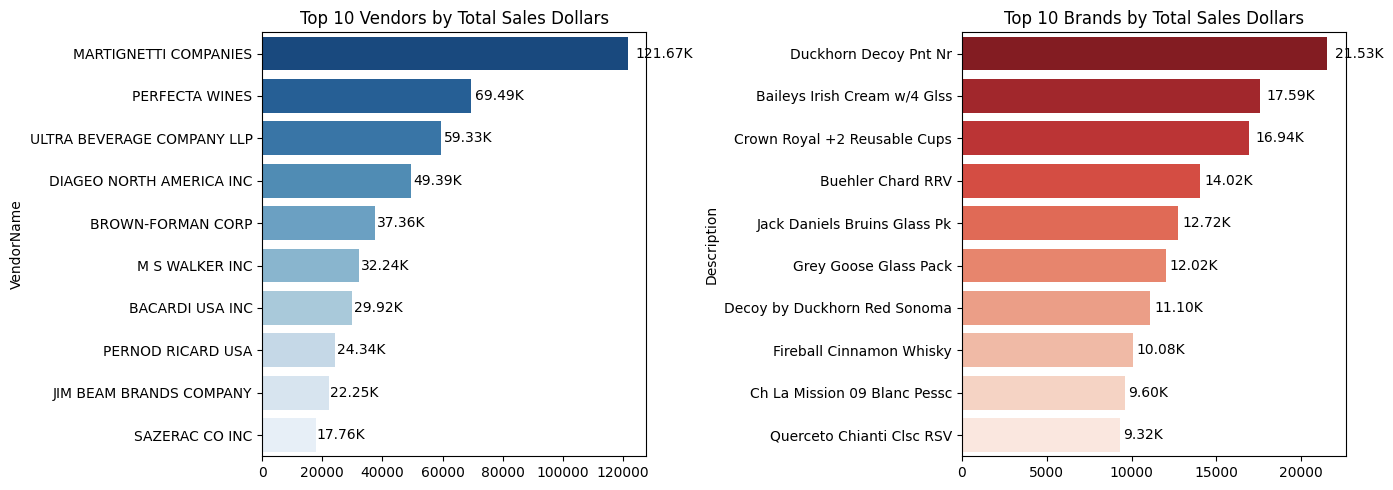

In [32]:
plt.figure(figsize=(14,5))

#plot for top vendors
plt.subplot(1,2,1)
ax1 = sns.barplot(x=top_vendors.values, y=top_vendors.index, palette="Blues_r")
plt.title("Top 10 Vendors by Total Sales Dollars")

for bar in ax1.patches:
    ax1.text(bar.get_width() + (bar.get_width()*0.02), bar.get_y() + bar.get_height()/2,
             format_dollars(bar.get_width()),
             ha='left', va='center',fontsize=10,color='black')

plt.subplot(1,2,2)
ax2 = sns.barplot(x=top_brands.values, y=top_brands.index.astype(str), palette="Reds_r")
plt.title("Top 10 Brands by Total Sales Dollars")

for bar in ax2.patches:
    ax2.text(bar.get_width() + (bar.get_width()*0.02), 
             bar.get_y() + bar.get_height()/2,
             format_dollars(bar.get_width()),
             ha='left', va='center',fontsize=10,color='black')

plt.tight_layout()
plt.show()

vendors that contribute the most to total purchase dollars

In [34]:
vendor_performance = df.groupby('VendorName').agg({
    'TotalPurchaseDollars': 'sum',
    'GrossProfit': 'sum',
    'TotalSalesDollars': 'sum',
}).reset_index()

In [52]:
vendor_performance['PurchaseContribution'] = vendor_performance['TotalPurchaseDollars']/vendor_performance['TotalPurchaseDollars'].sum()*100

In [53]:
vendor_performance = round(vendor_performance.sort_values('PurchaseContribution', ascending=False),2)

In [54]:
top_vendors = vendor_performance.head(10)
top_vendors['TotalSalesDollars']= top_vendors['TotalSalesDollars'].apply(lambda x:format_dollars(x))
top_vendors['TotalPurchaseDollars']= top_vendors['TotalPurchaseDollars'].apply(lambda x:format_dollars(x))
top_vendors['GrossProfit']= top_vendors['GrossProfit'].apply(lambda x:format_dollars(x))
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution
30,MARTIGNETTI COMPANIES,71.15K,50.53K,121.67K,26.37
38,PERFECTA WINES,32.96K,36.54K,69.49K,12.22
59,ULTRA BEVERAGE COMPANY LLP,22.23K,37.10K,59.33K,8.24
1,BACARDI USA INC,14.85K,15.07K,29.92K,5.51
28,M S WALKER INC,11.06K,21.18K,32.24K,4.10
12,DIAGEO NORTH AMERICA INC,10.43K,38.96K,49.39K,3.86
2,BANFI PRODUCTS CORP,8.68K,1.70K,10.38K,3.22
23,JIM BEAM BRANDS COMPANY,8.49K,13.76K,22.25K,3.15
39,PERNOD RICARD USA,7.96K,16.38K,24.34K,2.95
40,PINE STATE TRADING CO,7.20K,9.88K,17.08K,2.67


In [55]:
top_vendors['PurchaseContribution'].sum()

72.29

In [56]:
top_vendors['CumulativeContribution'] = top_vendors['PurchaseContribution'].cumsum()
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution,CumulativeContribution
30,MARTIGNETTI COMPANIES,71.15K,50.53K,121.67K,26.37,26.37
38,PERFECTA WINES,32.96K,36.54K,69.49K,12.22,38.59
59,ULTRA BEVERAGE COMPANY LLP,22.23K,37.10K,59.33K,8.24,46.83
1,BACARDI USA INC,14.85K,15.07K,29.92K,5.51,52.34
28,M S WALKER INC,11.06K,21.18K,32.24K,4.10,56.44
12,DIAGEO NORTH AMERICA INC,10.43K,38.96K,49.39K,3.86,60.30
2,BANFI PRODUCTS CORP,8.68K,1.70K,10.38K,3.22,63.52
23,JIM BEAM BRANDS COMPANY,8.49K,13.76K,22.25K,3.15,66.67
39,PERNOD RICARD USA,7.96K,16.38K,24.34K,2.95,69.62
40,PINE STATE TRADING CO,7.20K,9.88K,17.08K,2.67,72.29


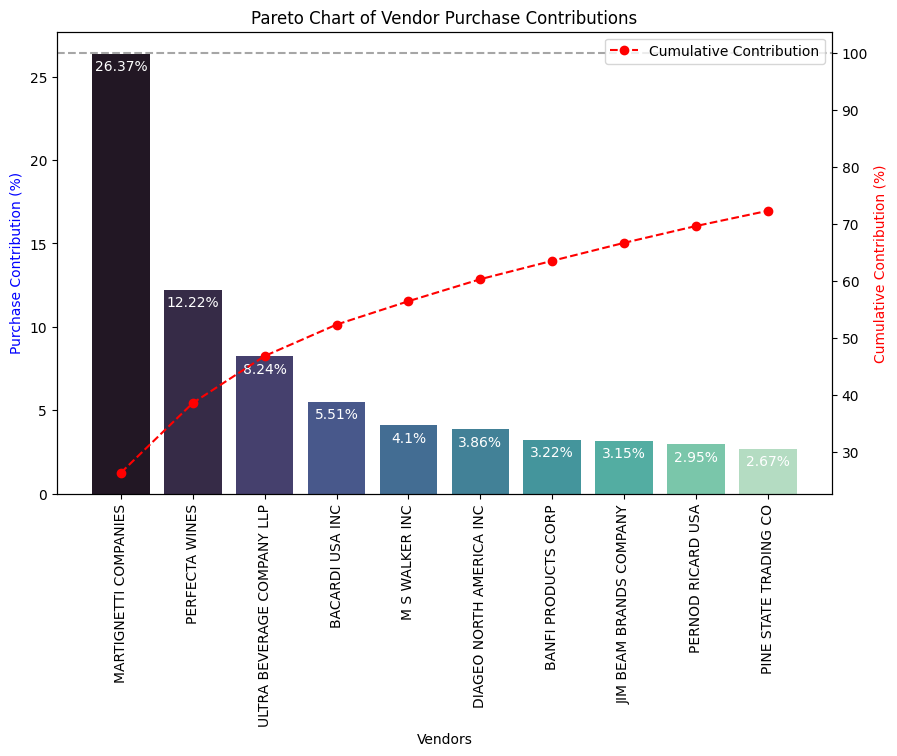

In [62]:
fig, ax1 = plt.subplots(figsize=(10,6))

sns.barplot(x=top_vendors['VendorName'], y=top_vendors['PurchaseContribution'], palette="mako", ax=ax1)

for i, value in enumerate(top_vendors['PurchaseContribution']):
    ax1.text(i, value - 1, str(value)+'%', ha='center', fontsize=10, color="white")

ax2 = ax1.twinx()
ax2.plot(top_vendors['VendorName'], top_vendors['CumulativeContribution'], color='red', marker='o', linestyle = 'dashed', label='Cumulative Contribution')

ax1.set_xticklabels(top_vendors['VendorName'], rotation=90)
ax1.set_ylabel('Purchase Contribution (%)', color='blue')
ax2.set_ylabel('Cumulative Contribution (%)', color='red')
ax1.set_xlabel('Vendors')
ax1.set_title('Pareto Chart of Vendor Purchase Contributions')

ax2.axhline(y=100,color='gray', linestyle='dashed', alpha=0.7)
ax2.legend(loc='upper right')

plt.show()

dependence on top vendors for total procurement

In [63]:
print(f"Total purchase contribution of top 10 vendors: {round(top_vendors['PurchaseContribution'].sum(),2)}%")

Total purchase contribution of top 10 vendors: 72.29%


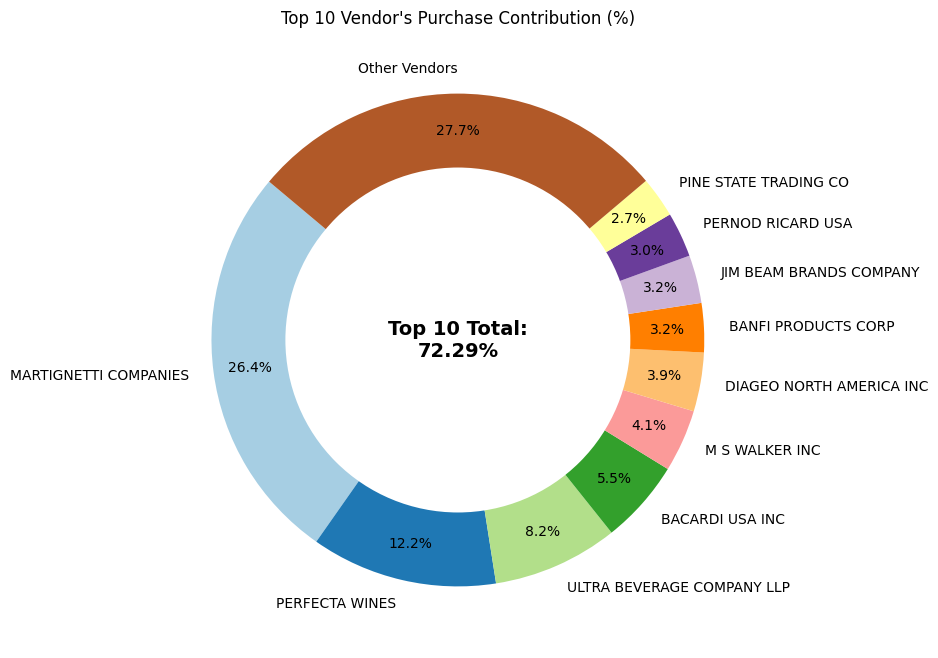

In [72]:
vendors = list(top_vendors['VendorName'].values)
purchase_contributions = list(top_vendors['PurchaseContribution'].values)
total_contribution = sum(purchase_contributions)
remaining_contribution = 100 - total_contribution

vendors.append("Other Vendors")
purchase_contributions.append(remaining_contribution)

fig,ax = plt.subplots(figsize=(8,8))
colors = plt.cm.Paired(np.linspace(0, 1, len(vendors)))
wedges, texts, autotexts = ax.pie(purchase_contributions, labels=vendors, autopct='%1.1f%%',
                                  startangle=140, pctdistance=0.85, colors=colors)

centre_circle = plt.Circle((0,0),0.70,fc="white")
fig.gca().add_artist(centre_circle)

plt.text(0,0,f"Top 10 Total:\n{total_contribution:.2f}%", fontsize=14, fontweight='bold', ha='center', va='center')

plt.title("Top 10 Vendor's Purchase Contribution (%)")
plt.show()

check if purchasing in bulk reduces unit price and what is optimal purchase volume for cost savings

In [69]:
df['UnitPurchasePrice'] = df['TotalPurchaseDollars'] / df['TotalPurchaseQuantity']


In [70]:
df["OrderSize"] = pd.qcut(df["TotalPurchaseQuantity"],q=3,labels=["Small","Medium","Large"])

In [73]:
df.groupby('OrderSize')[['UnitPurchasePrice']].mean()

,UnitPurchasePrice
OrderSize,
Small,52.915153
Medium,17.355436
Large,10.616300


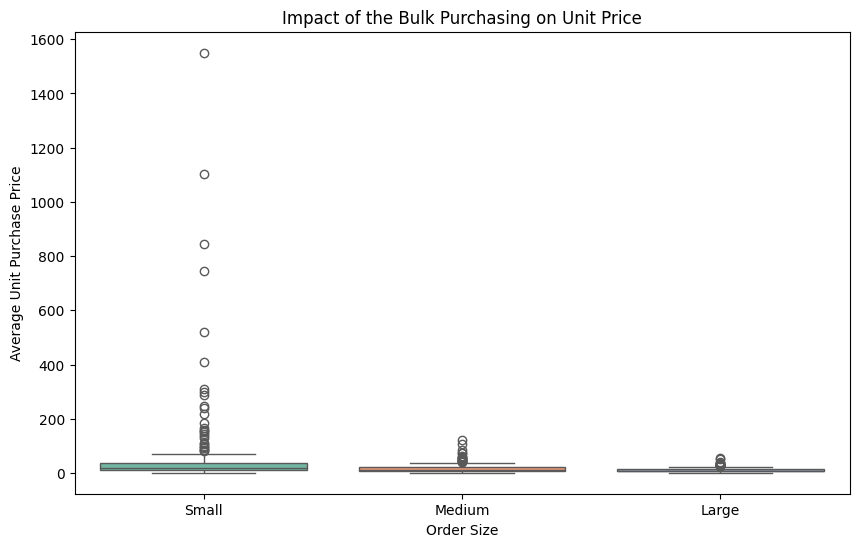

In [75]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df,x="OrderSize",y="UnitPurchasePrice",palette="Set2")
plt.title("Impact of the Bulk Purchasing on Unit Price")
plt.xlabel("Order Size")
plt.ylabel("Average Unit Purchase Price")
plt.show()


vendors buying in bulk get the lowest unit price, meaning higher margins if they can manage inventory effieciently.
The price difference between Small and Large orders is substantial.
This suggests that bulk pricing strategies successfully encourage vendors to purchase in larger volumes, leading to higher
overall sales despite lower per unit revenue.

vendors having low inventory turnover, showing excess stock and slow moving products

In [80]:
df[df['StockTurnOver']<1].groupby('VendorName')[['StockTurnOver']].mean().sort_values('StockTurnOver',ascending=True).head(10)

,StockTurnOver
VendorName,
DELICATO VINEYARDS INC,0.500000
BANFI PRODUCTS CORP,0.613313
CRUSH WINES,0.646538
DIAGEO CHATEAU ESTATE WINES,0.646584
FLAG HILL WINERY & VINEYARD,0.652174
MOET HENNESSY USA INC,0.681982
SURVILLE ENTERPRISES CORP,0.683333
R.P.IMPORTS INC,0.683333
KOBRAND CORPORATION,0.690476


95% confidence intervals for profit margins of top performing and low performing vendors

In [83]:
top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)

top_vendors = df[df["TotalSalesDollars"] >=top_threshold] ["ProfitMargin"].dropna()
low_vendors = df[df["TotalSalesDollars"] <=low_threshold] ["ProfitMargin"].dropna()

In [84]:
top_vendors

0      22.678723
1      19.145932
2      41.133262
3       2.992376
4       1.491896
         ...    
511    95.227956
540    99.752689
630    98.363541
646    99.866242
677    99.921409
Name: ProfitMargin, Length: 171, dtype: float64

In [85]:
low_vendors

367     5.756398
373     2.564103
401     2.621594
407     0.643087
408     2.588173
         ...    
675    80.758226
679    70.909091
681    34.268537
682    91.806958
683    94.483294
Name: ProfitMargin, Length: 171, dtype: float64

In [89]:
df["UnsoldInventoryValue"] = (df["TotalPurchaseQuantity"] - df["TotalSalesQuantity"])*df["PurchasePrice"]
print("Total Unsold Capital :", format_dollars(df["UnsoldInventoryValue"].sum()))

Total Unsold Capital : -181910.82


In [ ]:
def confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data))
    t_critical = stats.t.ppf((1+confidence)/2,df=len(data)-1)
    margin_of_error = t_critical*std_err
    return mean_val,mean_val - margin_of_error, mean_val + margin_of_error

Top Vendors 95% CI : (51.20, 60.28), Mean:55.74
Low Vendors 95% CI : (39.98, 60.28), Mean:43.51


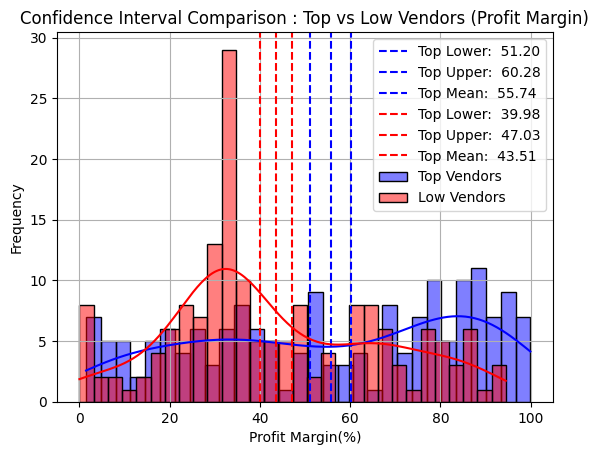

In [88]:
top_mean, top_lower, top_upper = confidence_interval(top_vendors)
low_mean, low_lower, low_upper = confidence_interval(low_vendors)

print(f"Top Vendors 95% CI : ({top_lower:.2f}, {top_upper:.2f}), Mean:{top_mean:.2f}")
print(f"Low Vendors 95% CI : ({low_lower:.2f}, {top_upper:.2f}), Mean:{low_mean:.2f}")

sns.histplot(top_vendors,kde=True,color="blue",bins=30,alpha=0.5,label="Top Vendors")
plt.axvline(top_lower, color="blue",linestyle="--",label=f"Top Lower: {top_lower : .2f}")
plt.axvline(top_upper,color="blue",linestyle="--",label=f"Top Upper: {top_upper : .2f}")
plt.axvline(top_mean,color="blue",linestyle="--",label=f"Top Mean: {top_mean : .2f}")

sns.histplot(low_vendors,kde=True,color="red",bins=30,alpha=0.5,label="Low Vendors")
plt.axvline(low_lower,color="red",linestyle="--",label=f"Top Lower: {low_lower : .2f}")
plt.axvline(low_upper,color="red",linestyle="--",label=f"Top Upper: {low_upper : .2f}")
plt.axvline(low_mean,color="red",linestyle="--",label=f"Top Mean: {low_mean : .2f}")

plt.title("Confidence Interval Comparison : Top vs Low Vendors (Profit Margin)")
plt.xlabel("Profit Margin(%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

 The confidence interval for low performing vendors is significantly higher than that of top performing vendors 
 This suggests that vendors with lower sales tend to maintain higher proft margins due to premium pricing or operational costs
 For high performing vendors : if they aim to improve profitability, they could explore selective price adjustments, cost optimizations, or bundling strategies
For low performing vendors: despite higher margins , their low sales volume indicate they need for better marketing , competitive pricing or improved distribution strategy

In [ ]:
df["UnsoldInventoryValue"] = (df["TotalPurchaseQuantity"] - df["TotalSalesQuantity"])*df["PurchasePrice"]
print("Total Unsold Capital :", format_dollars(df["UnsoldInventoryValue"].sum()))

Total Unsold Capital : -181910.82


is there significant difference in profit margins between top-performing and low performing vendors:

H0 (Null hypothesis) : There is no significant difference in the mean profit margins between top-performing and low performing vendors

H1 (Alternate Hypothesis) : The mean profit margins of top-performing and low performing vendors are significantly different

In [90]:
top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)

top_vendors = df[df["TotalSalesDollars"] >=top_threshold] ["ProfitMargin"].dropna()
low_vendors = df[df["TotalSalesDollars"] <=low_threshold] ["ProfitMargin"].dropna()

t_stat, p_value = ttest_ind(top_vendors,low_vendors,equal_var=False)

print(f"T-Statistics: {t_stat:.4f}, P-value: {p_value:.4f}")
if p_value<0.05:
    print("Reject H0: There is significant difference in the mean profit margins between top-performing and low performing vendors ")
else:
    print("Fail to Reject H0: There is no significant difference in the mean profit margins between top-performing and low performing vendors")

T-Statistics: 4.1998, P-value: 0.0000
Reject H0: There is significant difference in the mean profit margins between top-performing and low performing vendors 
